In [135]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard, LKV
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt

### Load model

In [136]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [137]:
t_span = (0, 15)
N = 512
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [138]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [139]:
x0, y0 = 1.75, 0.85

epsilon = 0.5
xi0 = (x0 - 1) / epsilon
eta0 = (y0 - 1) / epsilon

In [140]:
xi0, eta0

(1.5, -0.30000000000000004)

In [141]:
alpha_list = [0.2]
ic_list = [[xi0, eta0]]
epsilon_list = [epsilon]
p_list = [6]

In [142]:
xi0, eta0

(1.5, -0.30000000000000004)

## Lindstedt-Poincare method

perturbation order 0
perturbation order 1
9.095976436245573e-05


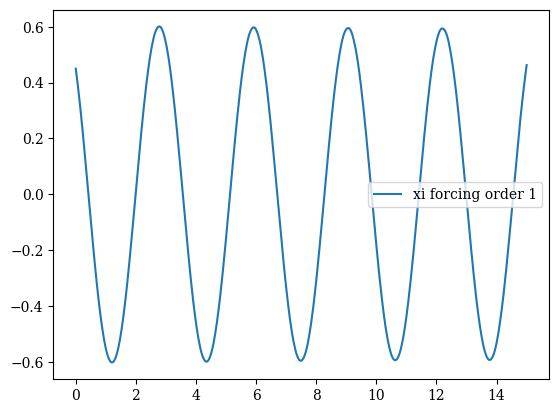

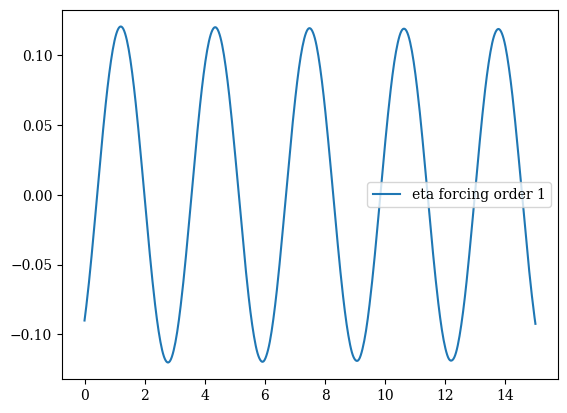

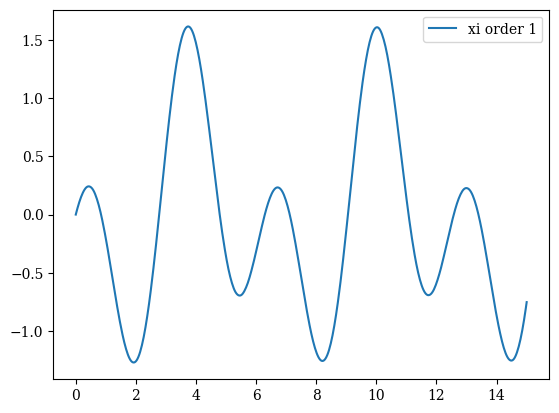

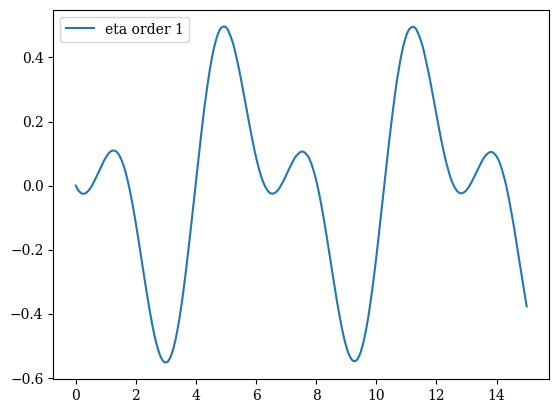

perturbation order 2
-0.10063121237717006


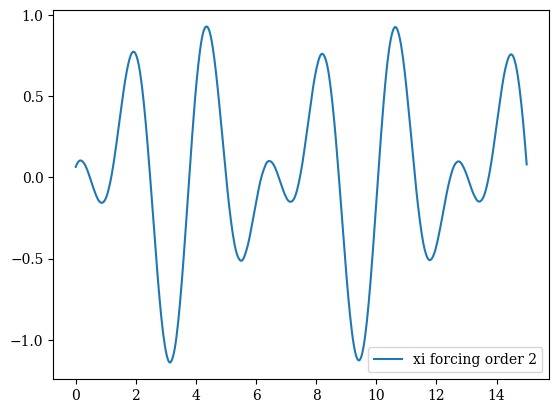

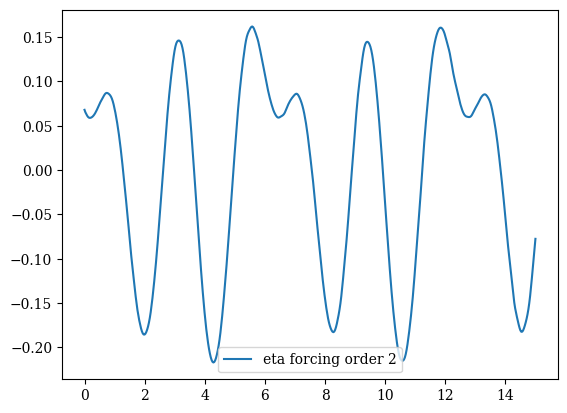

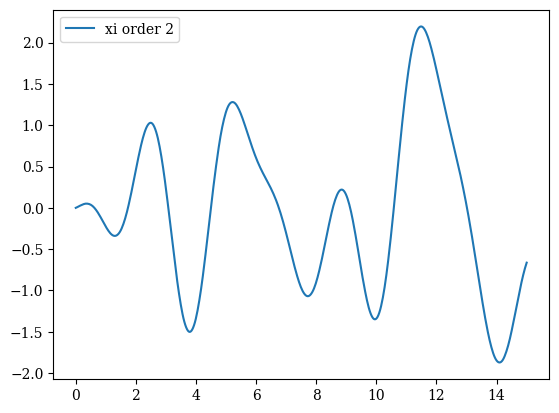

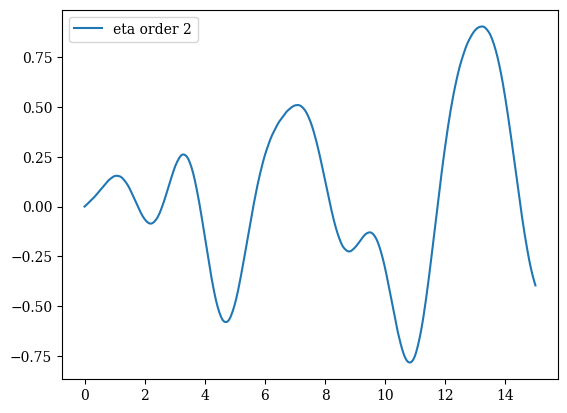

perturbation order 3
0.14277928273726517


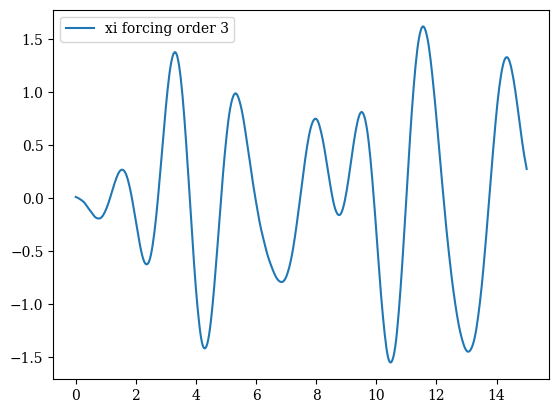

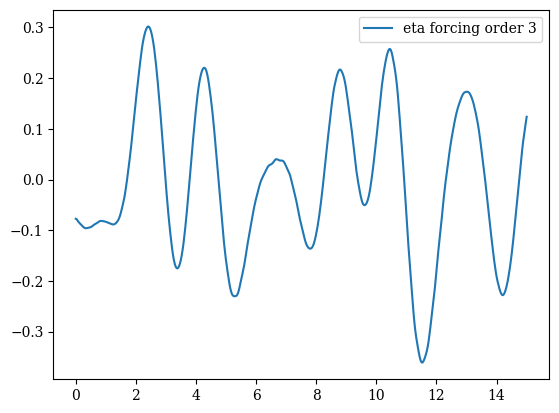

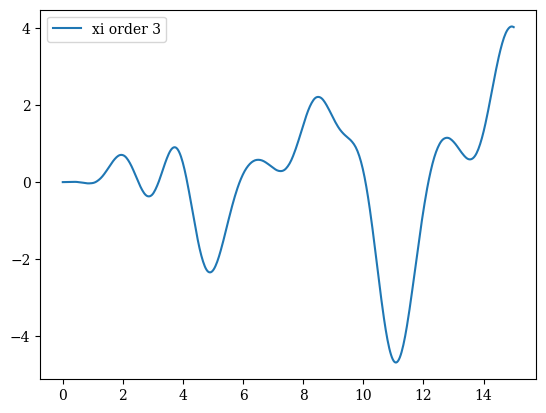

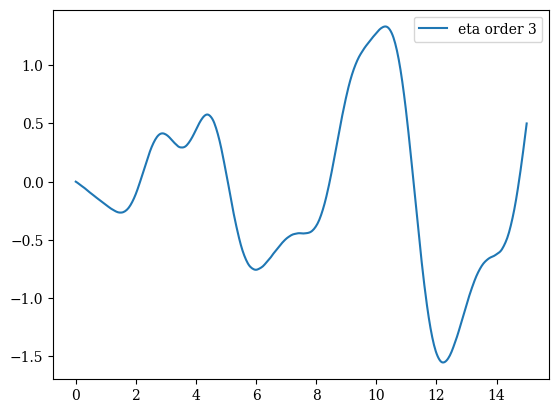

perturbation order 4
-0.17617629156065107


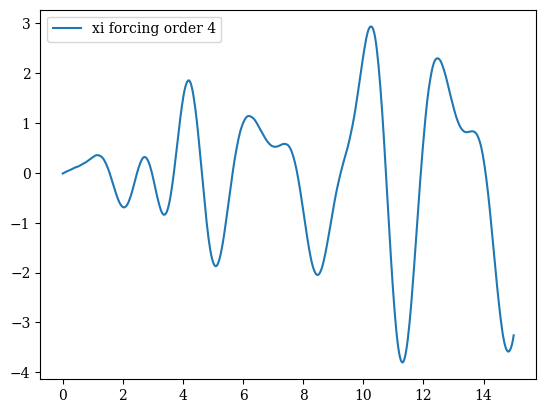

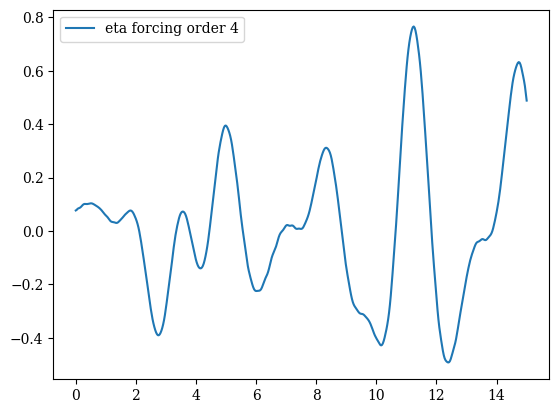

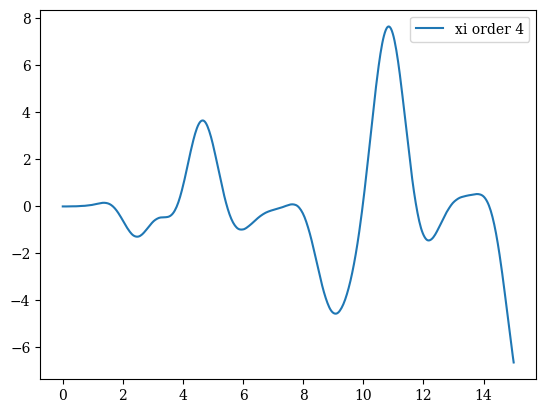

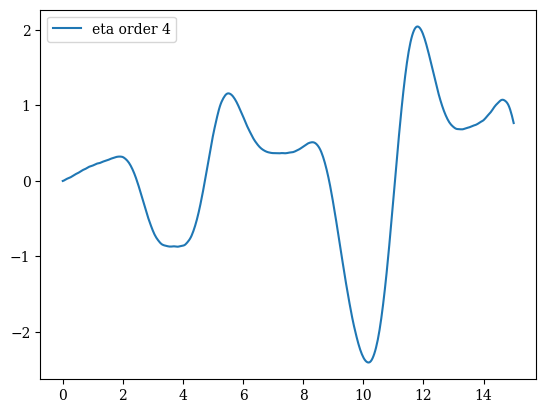

perturbation order 5
0.15008548280783532


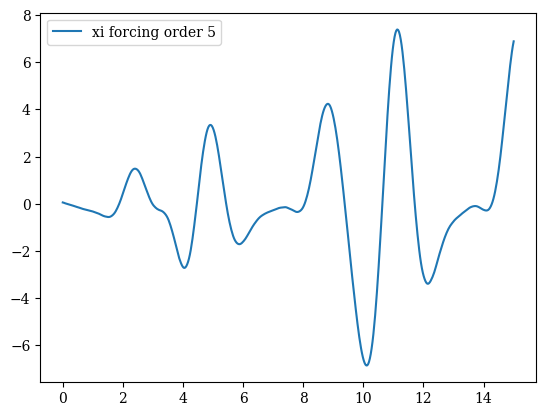

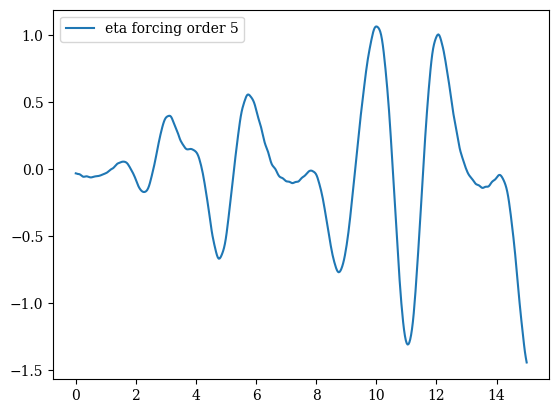

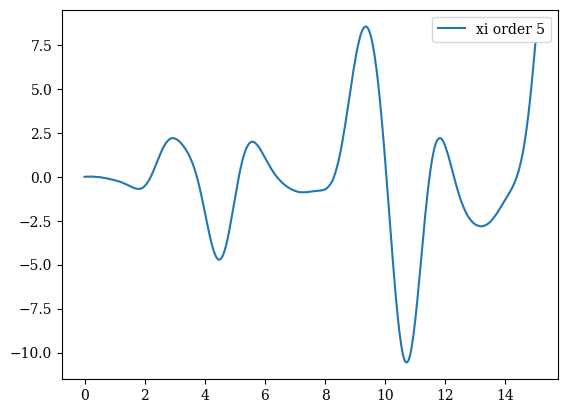

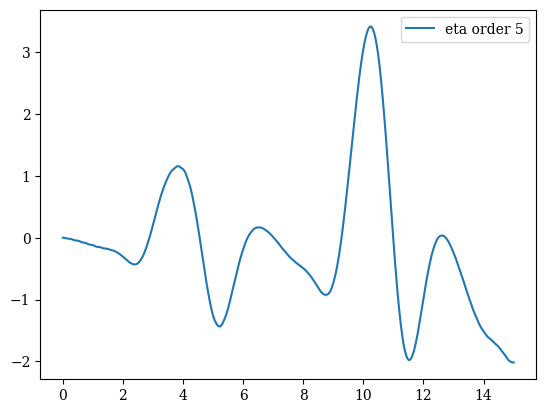

perturbation order 6
-0.07231213313350292


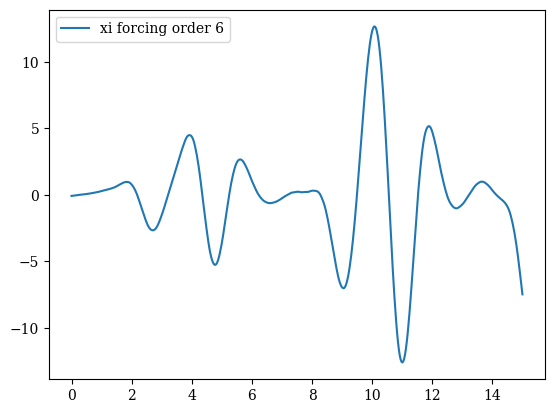

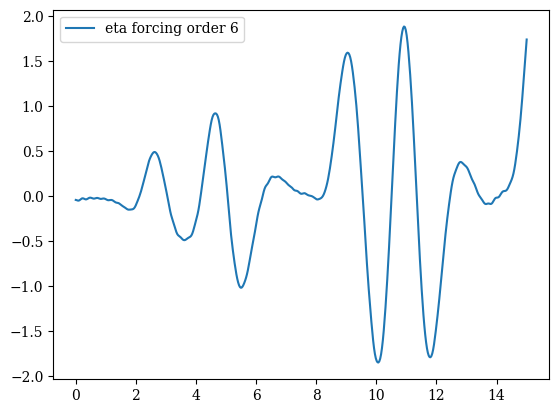

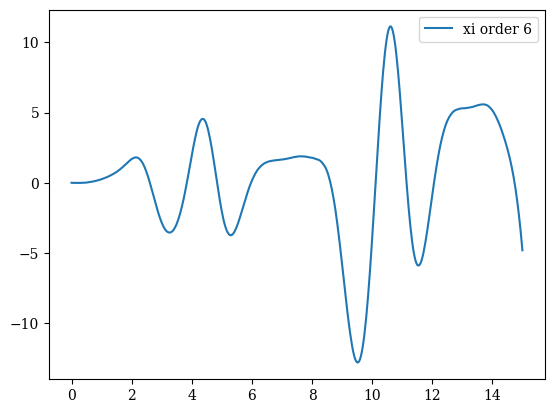

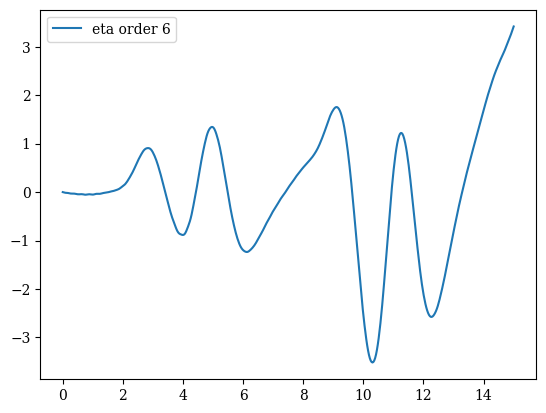

In [143]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution_LKV(epsilon_list, p_list, ic_list, alpha_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

In [144]:
w_sol

[[np.float64(0.4472135954999579),
  np.float64(9.095976436245573e-05),
  np.float64(-0.10063121237717006),
  np.float64(0.14277928273726517),
  np.float64(-0.17617629156065107),
  np.float64(0.15008548280783532),
  np.float64(-0.07231213313350292)]]

In [145]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-10, check_divergence=False))

w_final_list

[[np.float64(0.4472135954999579),
  np.float64(0.44725907538213916),
  np.float64(0.42210127228784666),
  np.float64(0.4399486826300048),
  np.float64(0.4289376644074641),
  np.float64(0.43362783574520897),
  np.float64(0.43249795866499796)]]

In [146]:
#_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
#w_teor

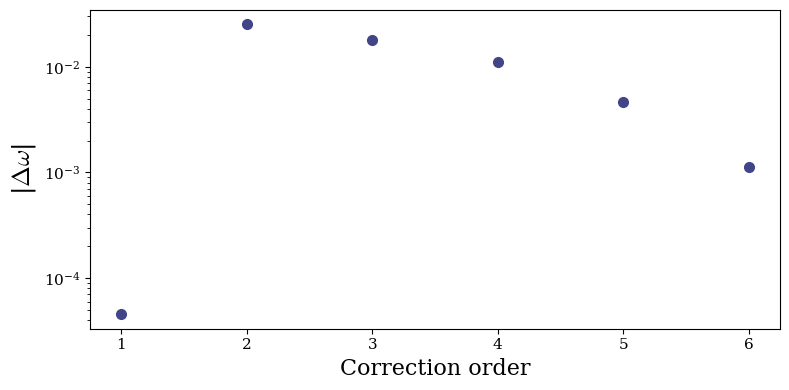

In [147]:
LPM.relative_error(w_final_list[0])
#LPM.w_absolute_error(w_final_list[0], w_teor)

In [148]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

In [149]:
NN_TL_solution_LPM

array([[ 1.49995478, -0.29996245],
       [ 1.534441  , -0.28224167],
       [ 1.56716028, -0.26402914],
       ...,
       [-0.9520857 ,  0.50145169],
       [-0.97227327,  0.48675987],
       [-0.99186123,  0.471258  ]], shape=(512, 2))

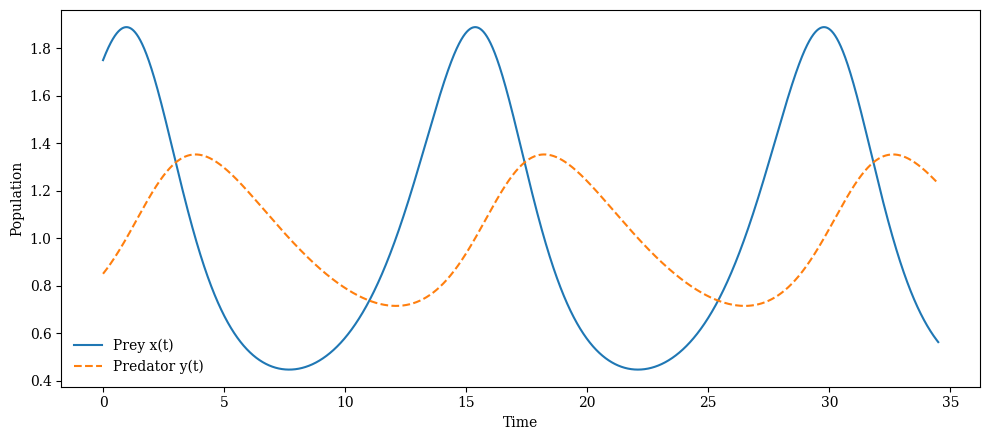

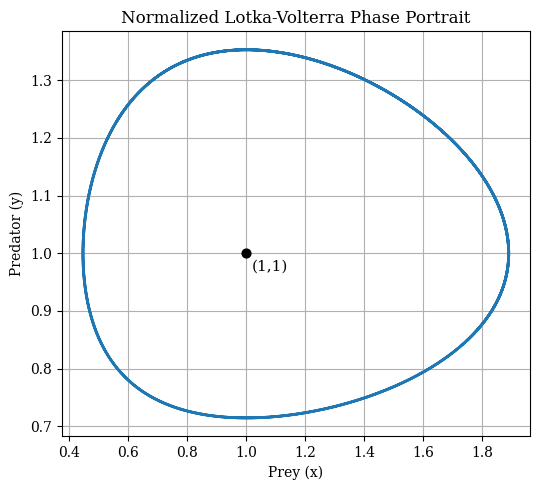

In [150]:
t_eval_num = np.linspace(0, 34.5, 51200)
ode = equations.lv_normalized(alpha_list[0])
sol = numerical.solve_ode_equation(ode, (0, 34.5), t_eval_num, [x0, y0])
x, y = sol

LKV.plot_numerical_LKV(x, y, t_eval_num)

In [151]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_lv_comparison(t_eval_lpm, t_eval_num, NN_TL_solution_LPM, x, y, epsilon_list):
    # --- Style settings ---
    label_fs  = 18
    tick_fs   = 14
    legend_fs = 14
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(12, 4.8))

    # --- Define consistent colors for (xi,x) and (eta,y) ---
    color_xi  = cm.viridis(0.15)  # i = 0
    color_eta = cm.viridis(0.55)  # i = 1

    # --- Numerical reference first (lighter colors) ---
    ax.plot(
        t_eval_num,
        x,
        label="$x$",
        color=color_xi,
        linewidth=2.0,
        alpha=0.7,
        zorder=1,
    )

    ax.plot(
        t_eval_num,
        y,
        label="$y$",
        color=color_eta,
        linewidth=2.0,
        alpha=0.7,
        zorder=1,
    )

    # --- PTL-PINN approximations last (bolder dashed lines) ---
    ax.plot(
        t_eval_lpm,
        1 + epsilon_list[0] * NN_TL_solution_LPM[:, 0],
        label=r"$1 + \varepsilon \xi$",
        color=color_xi,
        linewidth=2.4,
        linestyle=(0, (6, 3)),  # longer dashes
        marker="o",
        markersize=4.5,
        markevery=100,
        alpha=0.95,
        zorder=3,
    )

    ax.plot(
        t_eval_lpm,
        1 + epsilon_list[0] * NN_TL_solution_LPM[:, 1],
        label=r"$1 + \varepsilon \eta$",
        color=color_eta,
        linewidth=2.4,
        linestyle=(0, (6, 3)),  
        marker="s",
        markersize=4.5,
        markevery=100,
        alpha=0.95,
        zorder=3,
    )

    # --- Axis labels and ticks ---
    ax.set_xlabel("t", fontsize=label_fs, labelpad=6)
    ax.set_ylabel("Solution", fontsize=label_fs, labelpad=8)
    ax.tick_params(axis="both", labelsize=tick_fs)

    # --- Legend on top ---
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
        fontsize=legend_fs,
        frameon=False,
        handlelength=2.8,
        markerscale=1.2,
        labelspacing=0.4,
    )

    plt.tight_layout()
    plt.show()



/tmp/ipykernel_32920/3708410380.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


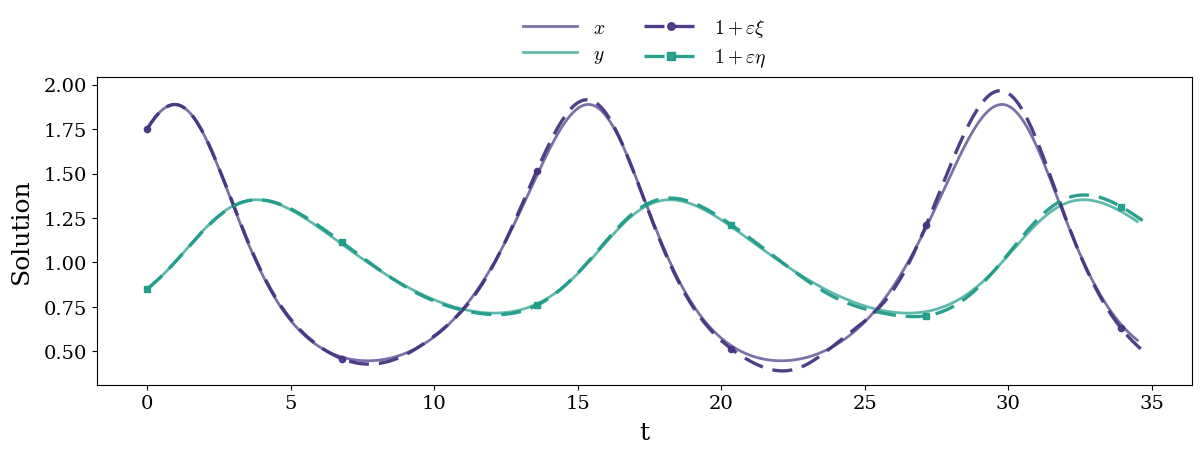

In [152]:
plot_lv_comparison(t_eval_lpm, t_eval_num, NN_TL_solution_LPM, x, y, epsilon_list)

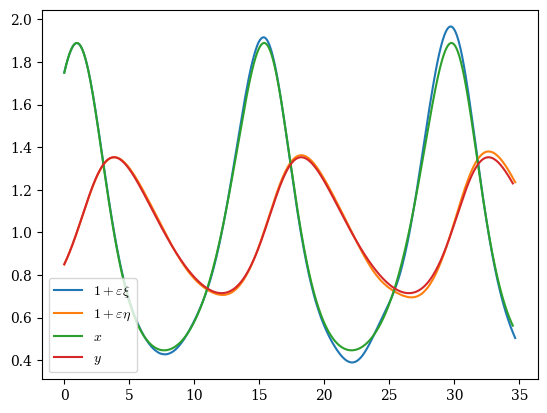

In [153]:
plt.plot(t_eval_lpm, 1 + epsilon_list[0] * NN_TL_solution_LPM[:, 0], label=r"$1 + \varepsilon \xi$")
plt.plot(t_eval_lpm, 1 + epsilon_list[0] * NN_TL_solution_LPM[:, 1], label=r"$1 + \varepsilon \eta$")
plt.plot(t_eval_num, x, label="$x$")
plt.plot(t_eval_num, y, label="$y$")
plt.legend()